# Secretory Reactions
Here we will map all the secretory reactions from the [Mammalian Secretory Pathway Reconstruction paper](https://www.nature.com/articles/s41467-019-13867-y) to the genes in our reconstruction.

1. Load Secretory Pathway Reactions

In [7]:
import datetime
import pickle

import re
import pandas as pd
import numpy as np
from google_sheet import GoogleSheet
from collections import defaultdict

import matplotlib.pyplot as plt
import plotly.express as px
from venn import venn
from upsetplot import UpSet
import matplotlib.pyplot as plt
from itertools import product

# Warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
##### ----- Generate datasets from Google Sheet ----- #####

#Credential file
KEY_FILE_PATH = 'credentials.json'

#CHO Network Reconstruction + Recon3D_v3 Google Sheet ID
Sec_Recon_SPREADSHEET_ID = '1DaAdZlvMYDqb7g31I5dw-ZCZH52Xj_W3FnQMFUzqmiQ'

# Initialize the GoogleSheet object
sec_recon_gsheet_file = GoogleSheet(Sec_Recon_SPREADSHEET_ID, KEY_FILE_PATH)

# Read data from SecRecon
sec_genes_sheet = 'SecRecon'
ontology_sheet = 'Ontology'

sec_genes = sec_recon_gsheet_file.read_google_sheet(sec_genes_sheet)
ontology = sec_recon_gsheet_file.read_google_sheet(ontology_sheet)

In [3]:
# Load the rest of the recons
Feizi = pd.read_excel('Input/Feizi_secRecon.xlsx', skiprows=4)
Lund = pd.read_excel('Input/Lund_secRecon.xlsx')
Lund['CHO_GeneID'] = Lund['CHO_GeneID'].astype(str).str.replace(r'\.0$', '', regex=True)
Jahir = pd.read_excel('Input/Jahir_secRecon.xlsx', sheet_name="Components (Human)")

/Users/pablodigiusto/miniforge3/envs/secrecon2.0/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [4]:
# Create a  mapping dicts

choentrez_humanentrez = {row['CHO ENTREZID']: row['HUMAN ENTREZID'] for _, row in sec_genes.dropna(subset=['CHO ENTREZID', 'HUMAN ENTREZID']).iterrows()}

humanens_humanentrez = {}
for _, row in sec_genes.dropna(subset=['HUMAN ENSEMBL', 'HUMAN ENTREZID']).iterrows():
    ensembl_ids = row['HUMAN ENSEMBL'].split(',')
    entrez_id = row['HUMAN ENTREZID']
    
    for ensembl_id in ensembl_ids:
        humanens_humanentrez[ensembl_id] = entrez_id

In [5]:
Feizi_humanentrez_list = []
for i,row in Feizi.iterrows():
    human_ensmbl = row['ensgid']
    if human_ensmbl in humanens_humanentrez.keys():
        Feizi_humanentrez_list.append(humanens_humanentrez[human_ensmbl])
    else:
        Feizi_humanentrez_list.append(human_ensmbl)

print(len(Feizi_humanentrez_list))

575


In [6]:
Lund_humanentrez_list = []
for i,row in Lund.iterrows():
    cho_entrez = row['CHO_GeneID']
    if cho_entrez in choentrez_humanentrez.keys():
        Lund_humanentrez_list.append(choentrez_humanentrez[cho_entrez])
    else:
        Lund_humanentrez_list.append(cho_entrez)

print(len(Lund_humanentrez_list))

807


In [7]:
Jahir_gene_list = Jahir['GeneID'].astype(str).tolist()

print(len(Jahir_gene_list))

271


In [8]:
sec_recon_list = list(sec_genes['HUMAN ENTREZID'])

print(len(sec_recon_list))

1127


In [9]:
# Create sets from lists
sec_recon_set = set(sec_recon_list)
Lund_gene_set = set(Lund_humanentrez_list)
Jahir_gene_set = set(Jahir_gene_list)
Feizi_gene_set = set(Feizi_humanentrez_list)

<Figure size 1000x1000 with 0 Axes>

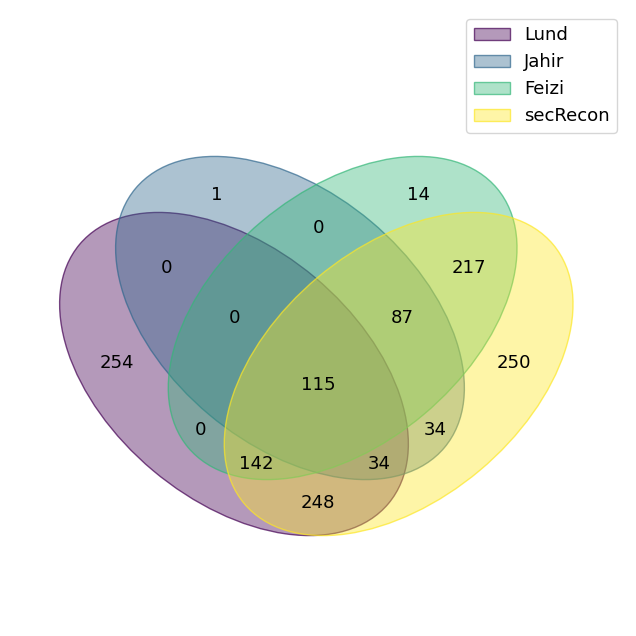

In [10]:
# Create a dictionary for the Venn diagram
venn_dict = {
    'Lund': Lund_gene_set,
    'Jahir': Jahir_gene_set,
    'Feizi': Feizi_gene_set,
    'secRecon': sec_recon_set
}

# Plot the Venn diagram
plt.figure(figsize=(10, 10))
venn(venn_dict)
plt.savefig('Plots/venn_diagram.png', dpi=300)
plt.show()

## 4. Subsystem Visualization

### 4.1 Sunburst Plot for Subsystem Organization

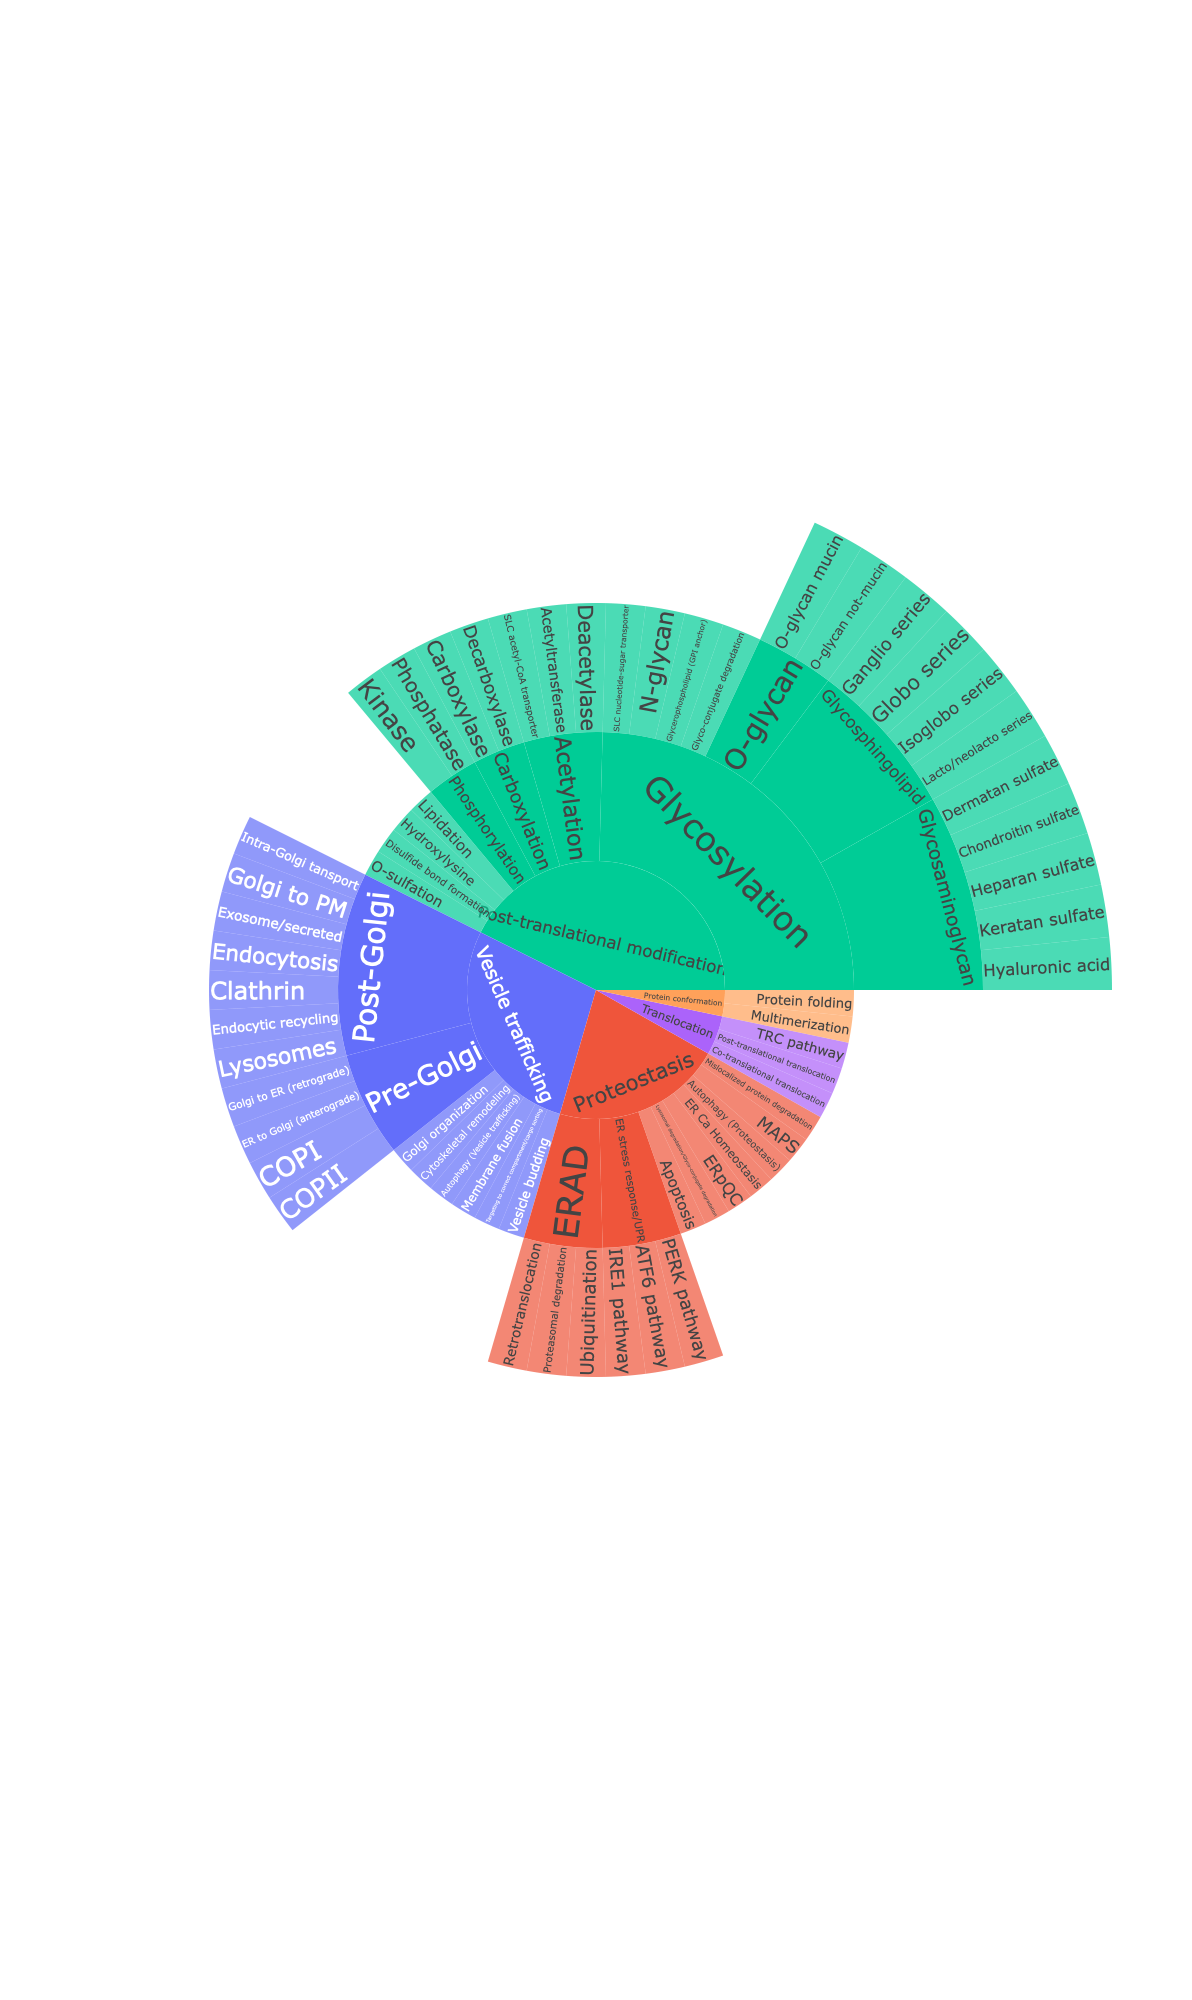

In [15]:
# Generate the Sunburst Plot
fig = px.sunburst(ontology, path=['System', 'Subsystem','Process','Subprocess'],
                  color='System')

fig.update_layout(width=2400, height=2000, font=dict(size=34),
                  plot_bgcolor='rgba(0,0,0,0)',  # Transparent plot background
                  paper_bgcolor='rgba(0,0,0,0)'  # Transparent paper background)
                 )

fig.write_html("Plots/sunburst_subsystems.html") # Save as interactive HTML file
fig.write_image("Plots/sunburst_subsystems.png", width=1200, height=1000)
# Show the plot
fig.show()

### 4.2 Upset Plot

In [9]:
# Load gene_dict
gene_dict_path = 'gene_dict.pkl'

# Open the file in binary mode and load the dictionary
with open(gene_dict_path, 'rb') as file:
    gene_dict = pickle.load(file)

In [10]:
# Define the list of all systems
systems_set = ['Protein conformation', 'Translocation', 'Post-translational modifications', 'Vesicle trafficking', 'Proteostasis']

# Create a DataFrame from gene_dict
df_genes = pd.DataFrame(0, index=gene_dict.keys(), columns=systems_set, dtype=bool)
for gene, details in gene_dict.items():
    for system in details['systems']:
        if system in systems_set:
            df_genes.at[gene, system] = True

# Count the occurrence of each combination in gene data
combination_counts = df_genes.groupby(list(systems_set)).size()

# Generate all possible combinations of True/False for these systems
combinations = list(product([True, False], repeat=len(systems_set)))

# Create a DataFrame from these combinations
df_combinations = pd.DataFrame(combinations, columns=systems_set, dtype=bool)

# Initialize 'Count' column to zero for all possible combinations
df_combinations['Count'] = 0

# Map the counted combinations from the genes to the new DataFrame
for idx, count in combination_counts.items():
    # Create a tuple of boolean values (index) in the same order as df_combinations columns
    idx_bool = tuple(idx[df_combinations.columns.get_loc(sys)] for sys in systems_set)
    df_combinations.loc[(df_combinations[list(systems_set)] == idx_bool).all(axis=1), 'Count'] = count

df_combinations = df_combinations[df_combinations['Count'] > 0]
df_combinations = df_combinations.sort_values(by='Count', ascending=False)
df_combinations = df_combinations.reset_index(drop=True)

# Transform the df to series multi index
df_combinations.set_index(list(systems_set), inplace=True)
series_combinations = df_combinations['Count']
series_combinations.name = None  # Removing the name of the series

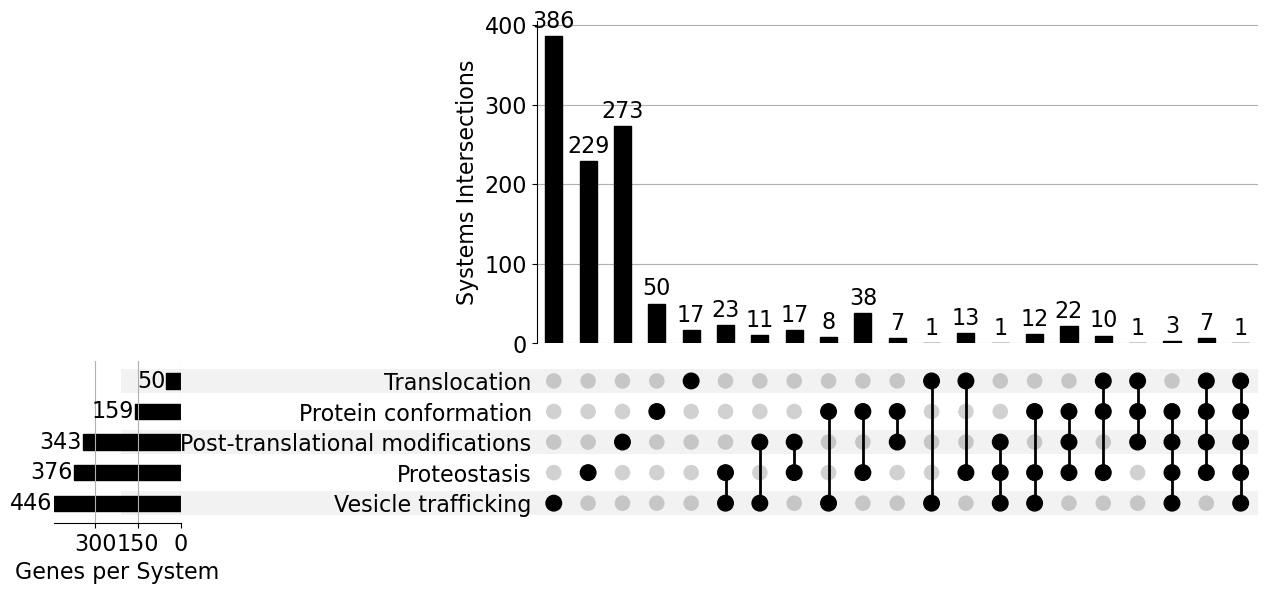

In [29]:
# Increase font size globally
plt.rcParams.update({'font.size': 16})

# Assuming 'series_combinations' is already defined and prepared
upset = UpSet(series_combinations, show_counts=True)

# Create the plot with adjusted figure size
fig = plt.figure(figsize=(10, 8))  # Width of 10 inches and height of 8 inches
upset.plot(fig=fig)

axes = fig.get_axes()
if axes:
    axes[2].set_xlabel('Genes per System')
    axes[2].xaxis.set_major_locator(plt.MaxNLocator(3))
    axes[2].set_position([axes[2].get_position().x0 - 0.046, axes[2].get_position().y0, axes[2].get_position().width * 2, axes[2].get_position().height])
    axes[3].set_ylabel('Systems Intersections')
    axes[3].set_position([axes[3].get_position().x0, axes[3].get_position().y0, axes[3].get_position().width, axes[2].get_position().height * 2])

plt.savefig('Plots/upset_plot.png', dpi=300, bbox_inches='tight')
plt.show()